In [ ]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns


FIRST_DAY = datetime.datetime.strptime("2025-06-28", '%Y-%m-%d')
END_DAY = datetime.datetime.strptime("2025-07-10", '%Y-%m-%d')

In [63]:
# IGRA ducts

IGRA_FTP = "ftp://ftp.ncei.noaa.gov/pub/data/igra/derived/derived-por/"
IGRA_FILE = "../deploy_test/output/igra-datas/derived/ITM00016045-drvd.txt"
STATIONS_FILE = "../deploy_test/output/igra-datas/igra2-station-list.txt"
OUTPUT_CSV = "igra_ducts.csv"


DUCT_THRESHOLD = -157

def parse_igra_derived_file(filepath, target_year, target_month, target_day):
    with open(filepath, 'r') as file:
        lines = file.readlines()

    data = []
    current_sounding = None
    inside_target_day = False

    for line in lines:
        if line.startswith('#'):
            year = int(line[13:17])
            month = int(line[18:20])
            day = int(line[21:23])

            if year == target_year and month == target_month and day == target_day:
                inside_target_day = True
                if current_sounding:
                    data.append(current_sounding)
                current_sounding = {'date': (year, month, day), 'levels': []}
            else:
                inside_target_day = False
        elif inside_target_day and current_sounding:
            try:
                height = int(line[16:23].strip())
                N = int(line[144:151].strip())
                if height != -99999 and N != -99999:
                    current_sounding['levels'].append((height, N))
            except ValueError:
                continue

    if current_sounding and current_sounding['levels']:
        data.append(current_sounding)

    return data

def compute_gradients(levels):
    gradients = []
    for i in range(len(levels) - 1):
        h1, N1 = levels[i]
        h2, N2 = levels[i + 1]
        if h2 != h1:
            dN_dh = (N2 - N1) / (h2 - h1) * 1000  # N/km
            gradients.append((h1, dN_dh))
    return gradients


def detect_duct_zones(gradients, threshold = DUCT_THRESHOLD):
    duct_zones = []
    current_duct = None
    
    for h, g in gradients:
        if g < threshold:
            if current_duct is None:
                # Start new duct zone
                current_duct = {
                    'base_height': h,
                    'top_height': h,
                    'min_gradient': g,
                    'min_gradient_height': h
                }
            else:
                # Extend existing duct zone
                current_duct['top_height'] = h
                if g < current_duct['min_gradient']:
                    current_duct['min_gradient'] = g
                    current_duct['min_gradient_height'] = h
        else:
            if current_duct is not None:
                # Finalize current duct zone
                current_duct['thickness'] = current_duct['top_height'] - current_duct['base_height']
                duct_zones.append(current_duct)
                current_duct = None
    
    # Add last duct if file ends with duct
    if current_duct is not None:
        current_duct['thickness'] = current_duct['top_height'] - current_duct['base_height']
        duct_zones.append(current_duct)
    
    return duct_zones

def analyze_ducting_for_date(date):
    data = parse_igra_derived_file(
        IGRA_FILE, 
        date.year, 
        date.month, 
        date.day
    )
    
    if not data or not data[0]['levels']:
        return None
    
    gradients = compute_gradients(data[0]['levels'])
    duct_zones = detect_duct_zones(gradients)
    
    result = {
        'date': date.strftime('%Y-%m-%d'),
        'duct_present': len(duct_zones) > 0,
        'num_ducts': len(duct_zones),
        'min_gradient': 0,
        'ducts': []
    }
    
    min_gradient = 0
    for i, duct in enumerate(duct_zones, 1):
        duct_info = {
            f'duct_{i}_base_height': duct['base_height'],
            f'duct_{i}_top_height': duct['top_height'],
            f'duct_{i}_thickness': duct['thickness'],
            f'duct_{i}_min_gradient': duct['min_gradient'],
            f'duct_{i}_min_gradient_height': duct['min_gradient_height']
        }
        result.update(duct_info)
        result['ducts'].append(duct)
        if duct['min_gradient'] < min_gradient:
            min_gradient = duct['min_gradient']

    result['min_gradient'] = min_gradient

    return result

def main():
    results = []
    current_date = FIRST_DAY

    while current_date <= END_DAY:
        print(f"Processing {current_date.strftime('%Y-%m-%d')}...")
        analysis = analyze_ducting_for_date(current_date)
        
        if analysis is None:
            print(f"No data for {current_date.strftime('%Y-%m-%d')}")
            current_date += datetime.timedelta(days=1)
            continue
        
        # Prepare flat record for CSV
        record = {
            'date': analysis['date'],
            'duct_present': analysis['duct_present'],
            'num_ducts': int(analysis['num_ducts']),
            'min_gradient': float(analysis['min_gradient'])
        }
        
        # Add duct information
        for i in range(1, analysis['num_ducts'] + 1):
            record.update({
                f'duct_{i}_base_height': analysis[f'duct_{i}_base_height'],
                f'duct_{i}_top_height': analysis[f'duct_{i}_top_height'],
                f'duct_{i}_thickness': analysis[f'duct_{i}_thickness'],
                f'duct_{i}_min_gradient': analysis[f'duct_{i}_min_gradient'],
                f'duct_{i}_min_gradient_height': analysis[f'duct_{i}_min_gradient_height']
            })
        
        results.append(record)
        current_date += datetime.timedelta(days=1)
    
    # Save results to CSV
    df = pd.DataFrame(results)
    
    # Reorder columns for better readability
    columns = ['date', 'duct_present', 'num_ducts', 'min_gradient']
    max_ducts = df['num_ducts'].max() if not df.empty else 0
    
    for i in range(1, max_ducts + 1):
        columns.extend([
            f'duct_{i}_base_height',
            f'duct_{i}_top_height',
            f'duct_{i}_thickness',
            f'duct_{i}_min_gradient',
            f'duct_{i}_min_gradient_height'
        ])
    
    df = df.reindex(columns=columns)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Ducting analysis saved to {OUTPUT_CSV}")

main()

Processing 2025-06-28...
Processing 2025-06-29...
Processing 2025-06-30...
Processing 2025-07-01...
Processing 2025-07-02...
Processing 2025-07-03...
Processing 2025-07-04...
Processing 2025-07-05...
Processing 2025-07-06...
Processing 2025-07-07...
Processing 2025-07-08...
Processing 2025-07-09...
No data for 2025-07-09
Processing 2025-07-10...
No data for 2025-07-10
Ducting analysis saved to igra_ducts.csv


In [64]:
# daily stats

DATA_FILE = "../deploy_test/output/data/helium_gateway_data.csv"
OUTPUT_STATS = "daily_propagation_stats.csv"


def calculate_daily_propagation_stats():
    try:
        df = pd.read_csv(DATA_FILE)
        df['date'] = pd.to_datetime(df['gwTime'], format='ISO8601').dt.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier : {e}")
        return

    # Dictionnaire pour stocker les stats par jour
    daily_stats = defaultdict(lambda: {
        'total_links': 0,
        'nlos_links': 0,
        'sum_distance': 0,
        'max_distance': 0,
        'gateways': set(),
        'end_nodes': set()
    })

    # Calculer les statistiques
    for _, row in df.iterrows():
        date = row['date']
        stats = daily_stats[date]
        
        stats['total_links'] += 1
        stats['sum_distance'] += float(row['dist_km'])
        
        if float(row['dist_km']) > stats['max_distance']:
            stats['max_distance'] = float(row['dist_km'])
        
        if str(row['visibility']) == "NLOS":
            stats['nlos_links'] += 1
        
        stats['gateways'].add(row['gatewayId'])

    results = []
    for date, stats in sorted(daily_stats.items()):
        avg_distance = stats['sum_distance'] / stats['total_links'] if stats['total_links'] > 0 else 0
        nlos_ratio = stats['nlos_links'] / stats['total_links'] if stats['total_links'] > 0 else 0
        
        results.append({
            'date': date,
            'total_links': stats['total_links'],
            'nlos_links': stats['nlos_links'],
            'nlos_ratio': round(nlos_ratio, 3),
            'avg_distance_km': round(avg_distance, 2),
            'max_distance_km': round(stats['max_distance'], 2),
            'unique_gateways': len(stats['gateways']),
        })

    # Sauvegarder en CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv(OUTPUT_STATS, index=False)
    print(f"Statistiques sauvegardées dans {OUTPUT_STATS}")

    return df_results

if __name__ == "__main__":
    stats = calculate_daily_propagation_stats()
    print(stats.head())

Statistiques sauvegardées dans daily_propagation_stats.csv
         date  total_links  nlos_links  nlos_ratio  avg_distance_km  \
0  2025-06-06           63          45       0.714            20.70   
1  2025-06-09          203         137       0.675            17.09   
2  2025-06-10          288         205       0.712            17.82   
3  2025-06-11          186         142       0.763            19.40   
4  2025-06-12          310         205       0.661            21.00   

   max_distance_km  unique_gateways  
0           127.74               24  
1           127.63               31  
2           127.67               38  
3           206.50               36  
4           202.82               42  


In [65]:
# merge data

DUCTING_CSV = "igra_ducts.csv"
PROPAGATION_CSV = "daily_propagation_stats.csv"
OUTPUT_CSV = "merged_data.csv"

def merge_ducting_propagation_data(ducting_file, propagation_file, output_file):
    # Charger les données
    df = pd.read_csv(ducting_file)
    df_propagation = pd.read_csv(propagation_file)
    
    # Convertir les colonnes date en datetime pour assurer une fusion correcte
    df['date'] = pd.to_datetime(df['date'], format='ISO8601').dt.strftime('%Y-%m-%d')
    df_propagation['date'] = pd.to_datetime(df_propagation['date'], format='ISO8601').dt.strftime('%Y-%m-%d')
    
    # Fusionner les données
    df_merged = pd.merge(df_propagation, df, on='date', how='outer')
    
    # Trier par date
    df_merged = df_merged.sort_values('date')
    
    # Sauvegarder le résultat
    df_merged.to_csv(output_file, index=False)
    print(f"Données fusionnées sauvegardées dans {output_file}")
    
    return df_merged

# Exemple d'utilisation
if __name__ == "__main__":
    # Fusionner les données
    merged_data = merge_ducting_propagation_data(DUCTING_CSV, PROPAGATION_CSV, OUTPUT_CSV)
    
    # Afficher un aperçu
    print("\nAperçu du tableau fusionné :")
    print(merged_data.head())

Données fusionnées sauvegardées dans merged_data.csv

Aperçu du tableau fusionné :
         date  total_links  nlos_links  nlos_ratio  avg_distance_km  \
0  2025-06-06           63          45       0.714            20.70   
1  2025-06-09          203         137       0.675            17.09   
2  2025-06-10          288         205       0.712            17.82   
3  2025-06-11          186         142       0.763            19.40   
4  2025-06-12          310         205       0.661            21.00   

   max_distance_km  unique_gateways duct_present  num_ducts  min_gradient  \
0           127.74               24          NaN        NaN           NaN   
1           127.63               31          NaN        NaN           NaN   
2           127.67               38          NaN        NaN           NaN   
3           206.50               36          NaN        NaN           NaN   
4           202.82               42          NaN        NaN           NaN   

   ...  duct_2_base_height 

Spearman rank correlation :  -0.7565454720444793


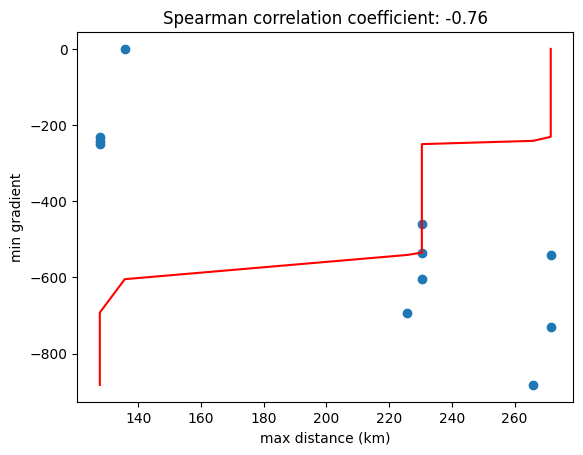

In [66]:
# correlation

df = pd.read_csv("merged_data.csv")

# On garde que les données non vides
df = df[df["total_links"].notna() & df["min_gradient"].notna()]

# En enlevant la ligne -1400 en gradiant
df = df[df["min_gradient"] > -1300]

y, x = df["min_gradient"], df["max_distance_km"]
rho, p_value = scipy.stats.spearmanr(x, y)

print("Spearman rank correlation : ", rho)

plt.scatter(x, y)
plt.plot(np.sort(x), np.sort(y), color='red')
plt.title("Spearman correlation coefficient: {:.2f}".format(rho))
plt.ylabel("min gradient")
plt.xlabel("max distance (km)")
plt.show()

Spearman rank correlation :  -0.6636363636363638


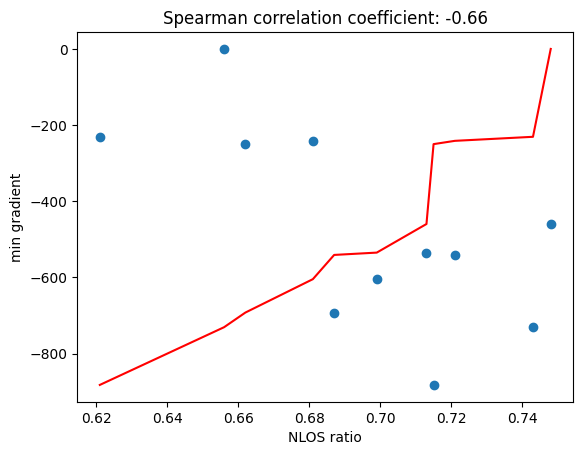

In [67]:
y, x = df["min_gradient"], df["nlos_ratio"]
rho, p_value = scipy.stats.spearmanr(x, y)

print("Spearman rank correlation : ", rho)

plt.scatter(x, y)
plt.plot(np.sort(x), np.sort(y), color='red')
plt.title("Spearman correlation coefficient: {:.2f}".format(rho))
plt.ylabel("min gradient")
plt.xlabel("NLOS ratio")
plt.show()

Spearman rank correlation :  -0.4383607343781343


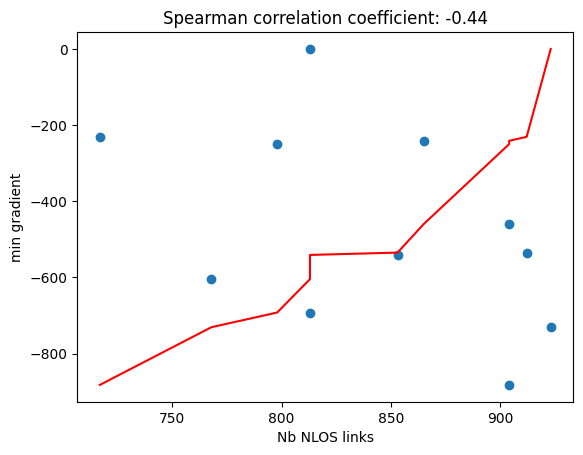

In [68]:
y, x = df["min_gradient"], df["nlos_links"]
rho, p_value = scipy.stats.spearmanr(x, y)

print("Spearman rank correlation : ", rho)

plt.scatter(x, y)
plt.plot(np.sort(x), np.sort(y), color='red')
plt.title("Spearman correlation coefficient: {:.2f}".format(rho))
plt.ylabel("min gradient")
plt.xlabel("Nb NLOS links")
plt.show()

Spearman rank correlation :  -0.7363636363636363


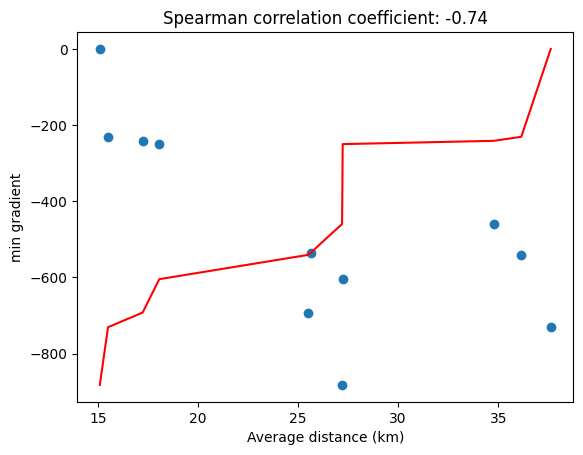

In [69]:
y, x = df["min_gradient"], df["avg_distance_km"]
rho, p_value = scipy.stats.spearmanr(x, y)

print("Spearman rank correlation : ", rho)

plt.scatter(x, y)
plt.plot(np.sort(x), np.sort(y), color='red')
plt.title("Spearman correlation coefficient: {:.2f}".format(rho))
plt.ylabel("min gradient")
plt.xlabel("Average distance (km)")
plt.show()

Spearman rank correlation :  -0.045454545454545456


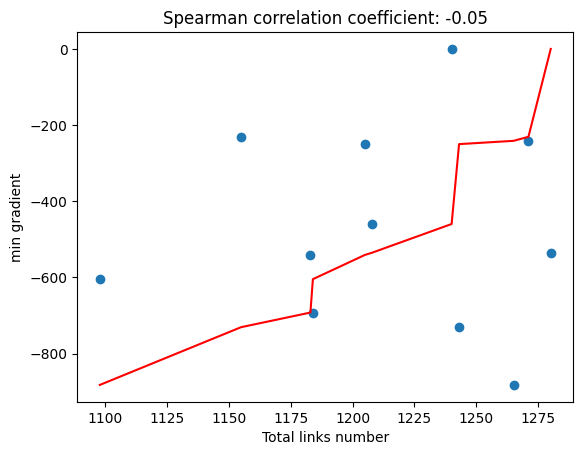

In [70]:
y, x = df["min_gradient"], df["total_links"]
rho, p_value = scipy.stats.spearmanr(x, y)

print("Spearman rank correlation : ", rho)

plt.scatter(x, y)
plt.plot(np.sort(x), np.sort(y), color='red')
plt.title("Spearman correlation coefficient: {:.2f}".format(rho))
plt.ylabel("min gradient")
plt.xlabel("Total links number")
plt.show()

Pearson rank correlation :  -0.8809701326872662


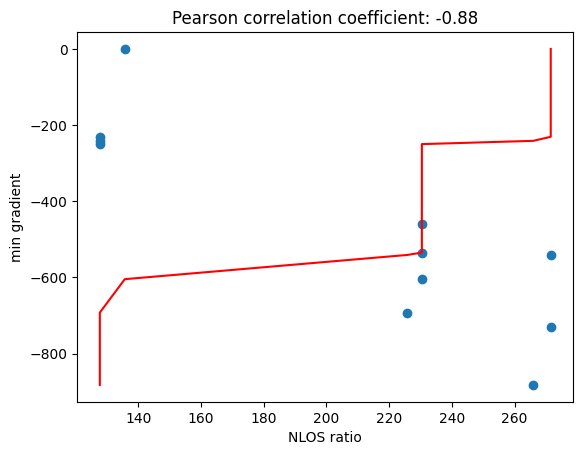

In [71]:
y, x = df["min_gradient"], df["max_distance_km"]
rho, p_value = scipy.stats.pearsonr(x, y)

print("Pearson rank correlation : ", rho)

plt.scatter(x, y)
plt.plot(np.sort(x), np.sort(y), color='red')
plt.title("Pearson correlation coefficient: {:.2f}".format(rho))
plt.ylabel("min gradient")
plt.xlabel("NLOS ratio")
plt.show()

In [72]:
# Analyse de groupes : les performances de liens changent-elles significativement les jours avec ducting comparé aux jours sans ducting?


Coefficient: -0.2051710822104015, Intercept: 107.69028479256076


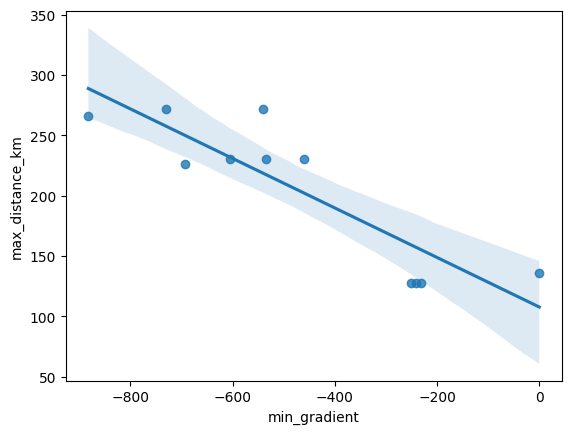

In [73]:
# Régression linéaire (prédire la distance)
model = LinearRegression()

x, y = df[["min_gradient"]], df["max_distance_km"]

model.fit(x, y)
sns.regplot(x="min_gradient", y="max_distance_km", data=df)

print(f"Coefficient: {model.coef_[0]}, Intercept: {model.intercept_}")

# Coeff négatif : plus le gradient est fort (petit), plus la distance est grande

<Axes: xlabel='date', ylabel='max_distance_km'>

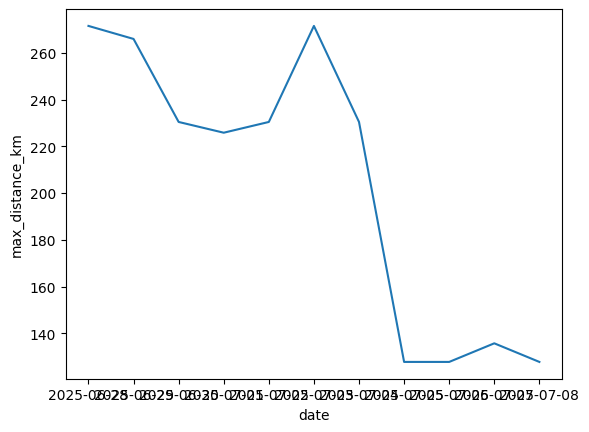

In [74]:
# Analyse temporelle
sns.lineplot(x="date", y="max_distance_km", data=df)
# sns.lineplot(x="date", y="nlos_ratio", data=df)
# sns.lineplot(x="date", y="duct_present", data=df, linestyle="--")


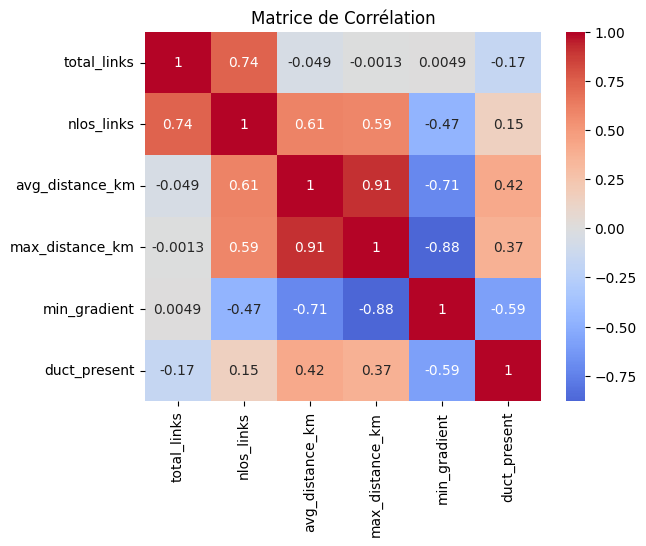

In [75]:
# analyse corrélation
# Sélection des colonnes pertinentes
cols = ['total_links', 'nlos_links', 'avg_distance_km', 'max_distance_km', 'min_gradient', 'duct_present']
df_numeric = df[cols]

# Matrice de corrélation
corr = df_numeric.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Matrice de Corrélation")
plt.show()

In [76]:
# régression linéaire multiple

# Préparation des données
x = df[['max_distance_km', 'nlos_links', 'duct_present']]  # Variables explicatives
y = df['min_gradient']  # Variable cible

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Modèle
model = LinearRegression()
model.fit(X_scaled, y)

# Coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [-198.54401592    9.54862457  -76.57022182]
Intercept: -469.80609187166243


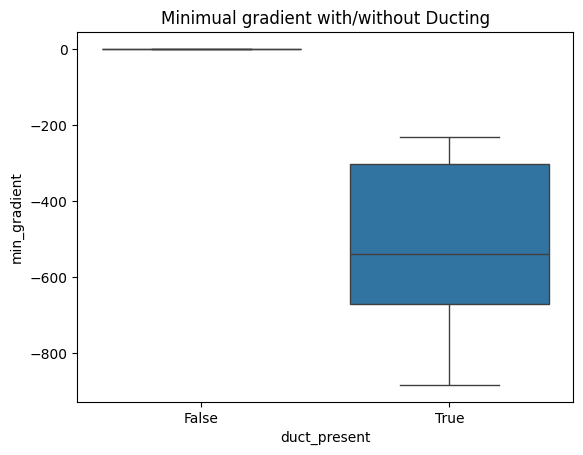

Test t: TtestResult(statistic=np.float64(-2.2012654398289726), pvalue=np.float64(0.055226485410414604), df=np.float64(9.0))


In [77]:
# analyse par groupes
# Boxplot pour gradient_min par statut de ducting
sns.boxplot(x='duct_present', y='min_gradient', data=df)
plt.title("Minimual gradient with/without Ducting")
plt.show()

# Test statistique
from scipy.stats import ttest_ind
group1 = df[df['duct_present'] == 1]['min_gradient']
group0 = df[df['duct_present'] == 0]['min_gradient']
print("Test t:", ttest_ind(group1, group0))

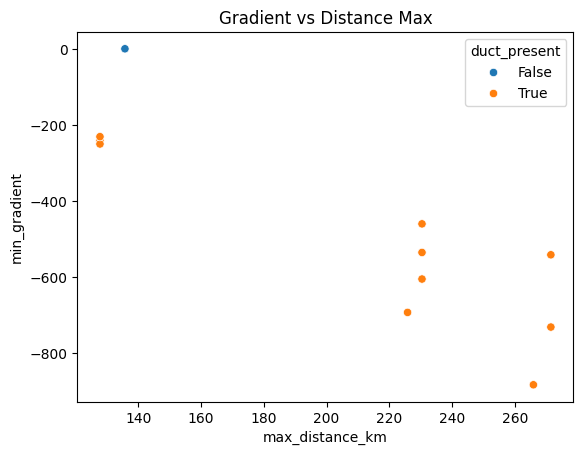

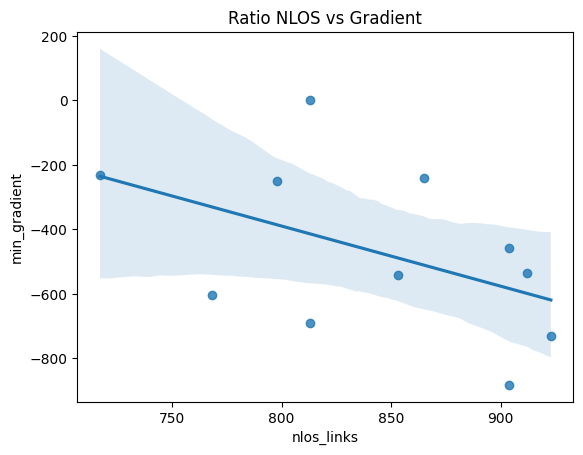

In [78]:
# Visualisations
# Scatter plot gradient vs distance max
sns.scatterplot(x='max_distance_km', y='min_gradient', hue='duct_present', data=df)
plt.title("Gradient vs Distance Max")
plt.show()

# Ratio NLOS vs Gradient
sns.regplot(x='nlos_links', y='min_gradient', data=df)
plt.title("Ratio NLOS vs Gradient")
plt.show()